# Matrix Factorization for Movie Recommendations in Python

In [1]:
!unzip ml-latest-small.zip

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


## Data Exploration

In [2]:
import pandas as pd
import numpy as np

# Read the csv data files
movies_df = pd.read_csv("ml-latest-small/movies.csv",
                        usecols=['movieId', 'title'],
                        dtype={'movieId': 'int32', 'title': 'str'})
ratings_df = pd.read_csv('ml-latest-small/ratings.csv',
                         usecols=['userId', 'movieId', 'rating'],
                         dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})
movies_df['movieId'] = movies_df['movieId'].apply(pd.to_numeric)

In [3]:
# Generate an R dataframe using pivot tables
# where Rows=Users and Columns=Movies, data=Ratings
R_df = ratings_df.pivot(index = 'userId', columns ='movieId', values = 'rating')
R_df.head()

# Calculate the mean ratings given by each user
users_mean=np.array(R_df.mean(axis=1))

# Fill up the NAN values of data with mean value inorder to keep the mean constant.
R_df=R_df.fillna(R_df.mean())

# Generate a Dataframe where each data had been subtracted by mean value of user
R_demean=R_df.sub(R_df.mean(axis=1), axis=0)

In [4]:
print(R_demean)

movieId    1         2         3         4         5         6         7       \
userId                                                                          
1        0.718247  0.150065  0.718247 -0.924610 -0.210325  0.718247 -0.096568   
2        0.658466  0.169354 -0.002848 -0.905321 -0.191035  0.683615 -0.077279   
3        0.663091  0.173979  0.001776 -0.900697 -0.186411  0.688239 -0.072654   
4        0.662843  0.173731  0.001528 -0.900944 -0.186659  0.687991 -0.072902   
5        0.737895  0.169713 -0.002490 -0.904963 -0.190677  0.683973 -0.076920   
...           ...       ...       ...       ...       ...       ...       ...   
606     -0.770671  0.161147 -0.011056 -0.913528 -0.199243  0.675407 -0.770671   
607      0.732203  0.164021 -0.008182 -0.910654 -0.196369  0.678281 -0.082612   
608     -0.749563 -1.249563 -1.249563 -0.892421 -0.178135  0.696515 -0.064378   
609     -0.261597  0.170221 -0.001982 -0.904454 -0.190169  0.684481 -0.076412   
610      1.706998  0.138816 

## Optimal value of K for Truncated SVD

In [5]:
n_users =int(max(ratings_df.userId))
n_items =int(max(ratings_df.movieId))

In [6]:
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import train_test_split

# Splitting into train and test sets
train_data = []
test_data = []

for user_id in ratings_df['userId'].unique():
    # Splitting ratings for each user into train and test sets
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    train = user_ratings.sample(frac=0.8, random_state=1)
    test = user_ratings.drop(train.index)
    
    # Adding train and test sets to the final train and test sets
    train_data.append(train)
    test_data.append(test)

# Combining all train and test sets into one DataFrame
train_data = pd.concat(train_data)
test_data = pd.concat(test_data)

In [7]:
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    a=int(line[1]-1)
    b=int(line[2]-1)
    c=line[3]
    train_data_matrix[a,b] = c

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    a=int(line[1]-1)
    b=int(line[2]-1)
    c=line[3]
    test_data_matrix[a, b] = c

In [8]:
train_data_matrix

array([[4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [9]:
test_data_matrix

array([[0., 0., 4., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
# Create our own RMSE measurement function:

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [11]:
# Generate predictions with by dot product of u,s, vt matrices of svds and measure these predictions with RMSE:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

a=[10, 20, 30, 40]
b=[]

for k in a:
    u, s, vt = svds(train_data_matrix, k = k)
    s = np.diag(s)
    X_pred = np.dot(np.dot(u, s), vt) + users_mean.reshape(-1, 1)
    b.append(round(rmse(X_pred, train_data_matrix),6))
    print('RMSE for k='+ str(k) + " : " + str(b[-1]))



RMSE for k=10 : 1.685776
RMSE for k=20 : 1.95969
RMSE for k=30 : 2.133087
RMSE for k=40 : 2.259723


In [12]:
min = float('inf')
index = 0
for i in range(0,len(b)):
    if(b[i]<min):
      min = b[i]
      index = i
K = a[index]

print("a : ", a)
print("b : ", b)
print(K)

a :  [10, 20, 30, 40]
b :  [1.685776, 1.95969, 2.133087, 2.259723]
10


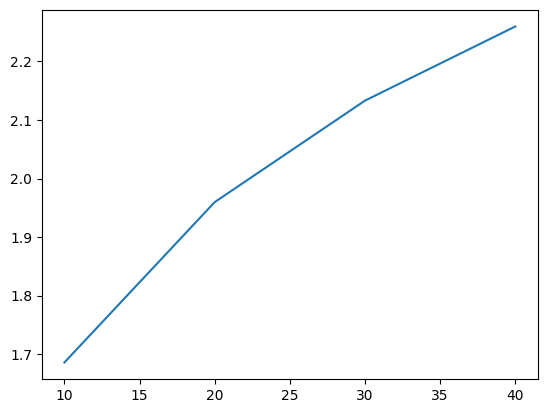

In [13]:
plt.plot(a,b)

## Singular Value Decomposition

In [14]:
from scipy.sparse.linalg import svds
print(K)
# Number of singular values and vectors to compute. Must be 1 <= k < min(R_demean.shape).
# svds is function to convert the R_demean to U, sigma, Vt matrix.
U, sigma, Vt = svds(train_data_matrix, k = K)

10


In [15]:
U

array([[-3.45947339e-02, -2.09136095e-03,  1.63801085e-02, ...,
         1.32658213e-02, -5.94900847e-02,  5.32988490e-02],
       [-1.05817603e-02,  1.22959430e-04,  9.87663119e-03, ...,
         4.26019211e-03,  1.46450668e-02,  5.43779021e-03],
       [ 1.29913650e-03, -1.20920523e-03, -1.60260191e-04, ...,
        -9.47098142e-04, -1.69461814e-03,  1.17856575e-03],
       ...,
       [ 1.89422397e-02, -3.38951467e-02, -1.15967938e-01, ...,
         3.23827253e-02, -1.52207848e-02,  1.16137693e-01],
       [-1.92679324e-03, -3.83608793e-03, -7.10497048e-03, ...,
         3.54232656e-02, -1.31776463e-02,  7.44353851e-03],
       [-2.03906162e-01, -1.60687796e-03, -3.65980077e-01, ...,
        -9.01765049e-02,  2.01630037e-01,  1.39793926e-01]])

In [16]:
sigma

array([102.48065461, 107.13912364, 112.99051226, 116.63585572,
       124.29991643, 133.50018003, 142.80298716, 155.97192189,
       187.97162263, 429.5058399 ])

In [17]:
Vt

array([[-0.02563443,  0.0123263 , -0.01527021, ...,  0.        ,
         0.        , -0.0010613 ],
       [ 0.01819566, -0.00058242,  0.01116223, ...,  0.        ,
         0.        , -0.00039811],
       [ 0.04149319, -0.0271028 ,  0.01611937, ...,  0.        ,
         0.        ,  0.00032898],
       ...,
       [ 0.06978265,  0.02034986,  0.00235201, ...,  0.        ,
         0.        ,  0.00010489],
       [-0.02601929,  0.00190481, -0.01613252, ...,  0.        ,
         0.        ,  0.00161292],
       [ 0.08241984,  0.03049494,  0.01499191, ...,  0.        ,
         0.        ,  0.00034819]])

In [18]:
# Converts the Diagonal matrix from 2D to 1D
sigma = np.diag(sigma)
sigma

array([[102.48065461,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        , 107.13912364,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        , 112.99051226,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , 116.63585572,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        124.29991643,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        , 133.50018003,   0.        ,   0.        ,
          0.        ,   0.        ],
       [  

## Making Predictions from the Decomposed Matrices

In [19]:
# Calculate the predicted ratings matrix by dot product of 
# U, sigma, Vt generated with addition of users_mean matrix.
users_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + users_mean.reshape(-1, 1)
print(users_predicted_ratings)
R_df = ratings_df.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Convert the matrix into dataframe
predictions_df = pd.DataFrame(users_predicted_ratings)
print(predictions_df)

[[7.08153132 4.83026547 5.05554852 ... 4.36637926 4.36637926 4.34564099]
 [4.11862198 3.92531085 3.90273415 ... 3.9482758  3.9482758  3.95868135]
 [2.47380899 2.45625012 2.45441164 ... 2.43589735 2.43589735 2.43445416]
 ...
 [6.5000346  4.64891092 4.34027955 ... 3.13417578 3.13417578 3.12879609]
 [3.79188734 3.52576463 3.33785347 ... 3.27027035 3.27027035 3.27206276]
 [4.40081996 6.15209142 3.47901726 ... 3.68855596 3.68855596 3.77693819]]
       0         1         2         3         4         5         6       \
0    7.081531  4.830265  5.055549  4.355846  4.520426  5.388685  4.346564   
1    4.118622  3.925311  3.902734  3.946697  3.954484  3.976320  3.879410   
2    2.473809  2.456250  2.454412  2.433840  2.434513  2.480696  2.432957   
3    5.056905  3.620599  3.815442  3.606677  3.675548  3.756184  3.712987   
4    4.513034  4.043042  3.762833  3.733638  3.903779  4.062458  4.065483   
..        ...       ...       ...       ...       ...       ...       ...   
605  5.114228  5.

In [ ]:
R_df

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
607,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608,2.5,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
predictions_df

,0,1,2,3,4,5,6,7,8,9,...,193599,193600,193601,193602,193603,193604,193605,193606,193607,193608
0,7.081531,4.830265,5.055549,4.355846,4.520426,5.388685,4.346564,4.358322,4.478807,5.864583,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.345641
1,4.118622,3.925311,3.902734,3.946697,3.954484,3.976320,3.879410,3.955534,3.936971,3.893123,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.958681
2,2.473809,2.456250,2.454412,2.433840,2.434513,2.480696,2.432957,2.435679,2.442355,2.480948,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.434454
3,5.056905,3.620599,3.815442,3.606677,3.675548,3.756184,3.712987,3.536479,3.551363,3.702278,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.546788
4,4.513034,4.043042,3.762833,3.733638,3.903779,4.062458,4.065483,3.754092,3.715295,4.269673,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.637114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,5.114228,5.038257,2.842715,3.826402,3.276616,5.150495,6.075779,3.360189,3.787979,3.942367,...,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.657399,3.617771
606,5.900690,4.244527,4.218469,3.808087,3.970816,4.672490,4.031822,3.814554,3.910396,5.100273,...,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.786096,3.775468
607,6.500035,4.648911,4.340280,3.103773,3.364919,6.139337,3.790390,3.483374,3.359757,6.643150,...,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.134176,3.128796
608,3.791887,3.525765,3.337853,3.328968,3.424114,3.680611,3.540052,3.358159,3.338552,3.770221,...,3.270270,3.270270,3.270270,3.270270,3.270270,3.270270,3.270270,3.270270,3.270270,3.272063


In [21]:
test_data["userId"]
userID=[]
movieID=[]
for i in range(test_data.shape[0]):
  userID.append(test_data["userId"].iloc[i])
  movieID.append(test_data["movieId"].iloc[i])

In [22]:
x=[]
for i in range(test_data.shape[0]):
  x.append(predictions_df[movieID[i]][userID[i]-1])

In [23]:
a=[]
for i in range(test_data.shape[0]):
  if (predictions_df[movieID[i]][userID[i]-1] < 3):
    a.append(0)
  else:
    a.append(1)
  # a.append(predictions_df[movieID[i]][userID[i]-1])

In [24]:
b=[]
for i in range(test_data.shape[0]):
  if (test_data["rating"].iloc[i]<3):
    b.append(0)
  else:
    b.append(1)  

In [25]:
test_data["predictions"]=x
test_data["predictions_binary"]=a
test_data["original_ratings_binary"]=b

In [26]:
truth=0
false=0
for i in range(test_data.shape[0]):
  if a[i]==b[i]:
    truth+=1
  else:
    false+=1

accuracy=truth*100/(truth+false)
print(accuracy)

80.86193215631819


## Making Movie Recommendations

In [27]:
# Movie recommendation function with arguments:
# 1. Predictions_df is the prediction dataframe
# 2. userID is the userID of the user for which movies to be recommended.
# 3. movies_df is the movies dataframe from the dataset.
# 4. rating_df is the original rating dataframe from the dataset.
# 5. variable to store the number of movies to be recommended.

def recommend_movies(predictions_df, userID, movies_df, ratings_df, n_recommendations=5):
    
    # Get user ID as per row.
    user_row = userID - 1
    
    # Get the user predictions from prediction dataframe in descending order.
    user_predictions = predictions_df.iloc[user_row].sort_values(ascending=False)
    
    # Get the user's data and merge with the movie information such as Title and Genres.
    user_data = ratings_df[ratings_df.userId == (userID)]
    user_full_data = (user_data.merge(movies_df, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full_data.shape[0]))
    print('Recommending the highest {0} predicted ratings movies that are not rated.'.format(n_recommendations))
    #
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    '''
    recommendations = (movies_df[~movies_df['movieId'].isin(user_full_data['movieId'])].
                       merge(pd.DataFrame(user_predictions).reset_index(), how = 'left',
                             left_on = 'movieId', right_on = 'movieId').
                       rename(columns = {user_row: 'Predictions'}).
                       sort_values('Predictions', ascending = False).
                       iloc[:n_recommendations, :-1]
                      )
    '''
    return user_full_data, user_predictions

previous_rated, recommended_movies = recommend_movies(predictions_df, 50, movies_df, ratings_df, 10)
print(previous_rated)
print(recommended_movies)

User 50 has already rated 310 movies.
Recommending the highest 10 predicted ratings movies that are not rated.
     userId  movieId  rating                             title
21       50      924     4.5      2001: A Space Odyssey (1968)
33       50     1204     4.5         Lawrence of Arabia (1962)
35       50     1208     4.5             Apocalypse Now (1979)
40       50     1251     4.5                 8 1/2 (8½) (1963)
121      50     7327     4.0                    Persona (1966)
..      ...      ...     ...                               ...
261      50   136305     1.0   Sharknado 3: Oh Hell No! (2015)
280      50   156607     1.0  The Huntsman Winter's War (2016)
222      50   103171     1.0              Schlussmacher (2013)
298      50   175485     0.5                 Death Note (2017)
247      50   122898     0.5             Justice League (2017)

[310 rows x 4 columns]
317     4.561685
295     4.537051
2857    4.524788
355     4.464359
2958    4.456189
          ...   
652    

In [ ]:
user_predictions = predictions_df.iloc[0].sort_values(ascending=False)[:10]
user_predictions

259     8.403801
1195    7.740413
1197    7.587991
1209    7.459805
1290    7.094817
0       7.081531
2857    7.042144
2570    7.039948
2027    7.036883
857     7.018862
Name: 0, dtype: float64

In [28]:
# The top 10 movies rated by the user
previous_rated.head(10)

,userId,movieId,rating,title
21,50,924,4.5,2001: A Space Odyssey (1968)
33,50,1204,4.5,Lawrence of Arabia (1962)
35,50,1208,4.5,Apocalypse Now (1979)
40,50,1251,4.5,8 1/2 (8½) (1963)
121,50,7327,4.0,Persona (1966)
28,50,1136,4.0,Monty Python and the Holy Grail (1975)
31,50,1199,4.0,Brazil (1985)
32,50,1201,4.0,"Good, the Bad and the Ugly, The (Buono, il bru..."
39,50,1232,4.0,Stalker (1979)
41,50,1252,4.0,Chinatown (1974)


In [32]:
import numpy as np

# Load the MovieLens dataset
data = np.genfromtxt('ml-latest-small/ratings.csv', delimiter=',', skip_header=1)

# Extract user and item IDs
user_ids = np.unique(data[:, 0]).astype(int)
item_ids = np.unique(data[:, 1]).astype(int)

# Construct the rating matrix
R = np.zeros((len(user_ids), len(item_ids)))
for row in data:
    user_idx = np.where(user_ids == row[0])[0][0]
    item_idx = np.where(item_ids == row[1])[0][0]
    R[user_idx, item_idx] = row[2]

# Perform SVD on the rating matrix
U, S, Vt = np.linalg.svd(R, full_matrices=False)

# Choose the number of latent factors
k = 20

# Compute the low-rank approximation of R
R_hat = U[:, :k] @ np.diag(S[:k]) @ Vt[:k, :]

# Calculate RMSE and MAE
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted)**2))

def mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

actual_ratings = R[R.nonzero()]
predicted_ratings = R_hat[R.nonzero()]
print("RMSE: ", rmse(actual_ratings, predicted_ratings))
print("MAE: ", mae(actual_ratings, predicted_ratings))

# Generate top 10 recommendations for each user
top_10_recommendations = {}
for i, user_id in enumerate(user_ids):
    user_idx = np.where(user_ids == user_id)[0][0]
    user_ratings = R[user_idx, :]
    user_ratings_hat = R_hat[user_idx, :]
    unrated_item_indices = np.where(user_ratings == 0)[0]
    predicted_ratings = user_ratings_hat[unrated_item_indices]
    sorted_indices = np.argsort(predicted_ratings)[::-1]
    top_10_item_ids = item_ids[unrated_item_indices[sorted_indices[:10]]]
    top_10_recommendations[user_id] = top_10_item_ids


RMSE:  2.3661750658526173
MAE:  1.9820137750540534
